# 3D Mesh Interpolation

Authors: Shiva Peri, Hima Gururaj, Nikolas Diamant

Paper References: 
[Lipschitz Regularization](https://arxiv.org/pdf/2202.08345v1.pdf),
[DeepSDF](https://arxiv.org/pdf/1901.05103.pdf)

Code References:
[Mesh to SDF](https://github.com/marian42/mesh_to_sdf),
[DeepSDF](https://github.com/facebookresearch/DeepSDF),

#### Importing Libraries

In [31]:
# !apt-get install x11-utils > /dev/null 2>&1 
# !pip install pyglet > /dev/null 2>&1 
# !apt-get install -y xvfb python-opengl > /dev/null 2>&1

# !pip install gym pyvirtualdisplay > /dev/null 2>&1

In [1]:
# use these specific versions so pytorch3d doesnt break

!pip install 'torch==1.6.0+cu101' -f https://download.pytorch.org/whl/torch_stable.html
!pip install 'torchvision==0.7.0+cu101' -f https://download.pytorch.org/whl/torch_stable.html
!pip install 'pytorch3d==0.2.5'

Looking in links: https://download.pytorch.org/whl/torch_stable.html
Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [3]:
%matplotlib inline

import os
import sys
import time
import numpy as np
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.distributions.bernoulli import Bernoulli

from tqdm.notebook import tqdm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80

In [4]:
import pytorch3d

from pytorch3d.renderer import (
    OpenGLPerspectiveCameras,
    PointLights,
    RasterizationSettings,
    TexturesVertex,
    look_at_view_transform,

    FoVOrthographicCameras, 
    PointsRasterizationSettings,
    PointsRenderer,
    PointsRasterizer,
    AlphaCompositor,
    NormWeightedCompositor
)

from pytorch3d.structures import (
    Meshes,
    Pointclouds
)

In [5]:
!wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
from plot_image_grid import image_grid

--2022-05-09 02:41:45--  https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1608 (1.6K) [text/plain]
Saving to: ‘plot_image_grid.py.2’

plot_image_grid.py. 100%[===================>]   1.57K  --.-KB/s    in 0s      

2022-05-09 02:41:45 (33.9 MB/s) - ‘plot_image_grid.py.2’ saved [1608/1608]



In [6]:
!pip install mesh-to-sdf

from mesh_to_sdf import sample_sdf_near_surface

import trimesh
import skimage
import skimage.measure

#### Data Loader

In [7]:
# Setup
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

print(device)

cuda:0


In [17]:
#!wget https://github.com/shivaPeri/16726-final-project/blob/main/data2.zip
!unzip ./data.zip


--2022-05-09 00:30:38--  https://github.com/shivaPeri/16726-final-project/blob/main/data2.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘data2.zip’

data2.zip               [ <=>                ] 122.66K  --.-KB/s    in 0.008s  

2022-05-09 00:30:39 (14.4 MB/s) - ‘data2.zip’ saved [125606]

Archive:  ./data2.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of ./data2.zip or
        ./data2.zip.zip, and cannot find ./data2.zip.ZIP, period.
['spikePillar.obj', 'smoothTube.obj']


In [10]:
mesh = trimesh.load('objects/' + os.listdir('objects')[0])
points, sdf = sample_sdf_near_surface(mesh, number_of_points=25000, surface_point_method='sample')
colors = np.zeros(points.shape)
colors[sdf < 0, 2] = 1
colors[sdf > 0, 0] = 1

verts = torch.Tensor(points).to(device)   
rgb = torch.Tensor(colors).to(device)
point_cloud = Pointclouds(points=[verts], features=[rgb])

In [21]:
# Initialize a camera.
R, T = look_at_view_transform(20, -20, 0)
cameras = FoVOrthographicCameras(device=device, R=R, T=T, znear=0.01)

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
# and blur_radius=0.0. Refer to raster_points.py for explanations of these parameters. 
raster_settings = PointsRasterizationSettings(
    image_size=512, 
    radius = 0.003,
    points_per_pixel = 10
)


# Create a points renderer by compositing points using an alpha compositor (nearer points
# are weighted more heavily). See [1] for an explanation.
rasterizer = PointsRasterizer(cameras=cameras, raster_settings=raster_settings)
renderer = PointsRenderer(
    rasterizer=rasterizer,
    compositor=AlphaCompositor()
)

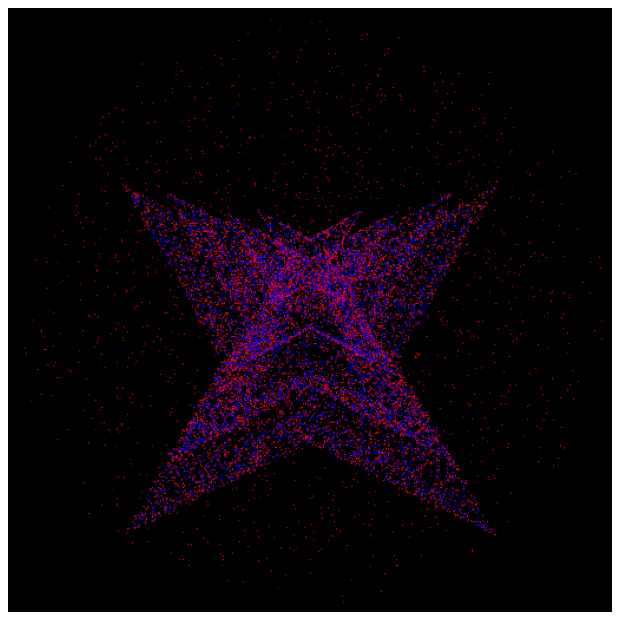

In [22]:
images = renderer(point_cloud)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.axis("off");

In [ ]:
# data loader

# TODO
class SDFDataLoader(DataLoader):
    def __init__(self, folder, batch_size, num_pts):
        self.objectFiles = ['objects/' + f for f in os.listdir('objects')]
        files = os.listdir('objects')

        self.meshes = [trimesh.load('objects/' + f) for f in files]
        for mesh in self.meshes:
          points, sdf = sample_sdf_near_surface(mesh, number_of_points=250000, surface_point_method='sample')


    def __len__(self):
        pass

    def __getitem__(self, index):
        pass


#### Model Architecture

In [ ]:
# Modified DeepSDF decoder from https://github.com/facebookresearch/DeepSDF/blob/main/networks/deep_sdf_decoder.py

#https://arxiv.org/pdf/2202.08345v1.pdf page 4
class Lipschitz(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(Lipschitz, self).__init__()

        self.lin = nn.Linear(in_dim, out_dim)
        self.ci = torch.nn.Parameter(1)
        self.ci.requires_grad = True
        
    def forward(self):
        Wi = self.lin.weight
        absrowsum = torch.sum(torch.abs(Wi), axis=1)
        scale = torch.minimum(1.0, self.ci/absrowsum)
        return Wi * scale[:,None]

class DeepSDFDecoder(nn.Module):
    def __init__(
        self,
        latent_size,
        dims,
        dropout=None,
        dropout_prob=0.0,
        norm_layers=(),
        latent_in=(),
        weight_norm=False,
        xyz_in_all=None,
        use_tanh=False,
        use_lip=True,             # this parameter applies Lipschitz
        latent_dropout=False,
    ):
        super(DeepSDFDecoder, self).__init__()

        dims = [latent_size + 3] + dims + [1]

        self.use_lip = use_lip

        self.num_layers = len(dims)
        self.norm_layers = norm_layers
        self.latent_in = latent_in
        self.latent_dropout = latent_dropout
        if self.latent_dropout:
            self.lat_dp = nn.Dropout(0.2)

        self.xyz_in_all = xyz_in_all
        self.weight_norm = weight_norm

        for layer in range(0, self.num_layers - 1):
            if layer + 1 in latent_in:
                out_dim = dims[layer + 1] - dims[0]
            else:
                out_dim = dims[layer + 1]
                if self.xyz_in_all and layer != self.num_layers - 2:
                    out_dim -= 3

            if weight_norm and layer in self.norm_layers:
                setattr(
                    self,
                    "lin" + str(layer),
                    nn.utils.weight_norm(nn.Linear(dims[layer], out_dim)),
                )
            else:
                # Lipschitz layer performes normalized linear layer + tracks losses
                if use_lip:
                    setattr(self, "lin" + str(layer), Lipschitz(dims[layer], out_dim))
                else:
                    setattr(self, "lin" + str(layer), nn.Linear(dims[layer], out_dim))

            if (
                (not weight_norm)
                and self.norm_layers is not None
                and layer in self.norm_layers
            ):
                setattr(self, "bn" + str(layer), nn.LayerNorm(out_dim))

        self.use_tanh = use_tanh
        if use_tanh:
            self.tanh = nn.Tanh()
        self.relu = nn.ReLU()

        self.dropout_prob = dropout_prob
        self.dropout = dropout
        self.th = nn.Tanh()

    # input: N x (L+3)
    def forward(self, input):
        xyz = input[:, -3:]

        if input.shape[1] > 3 and self.latent_dropout:
            latent_vecs = input[:, :-3]
            latent_vecs = F.dropout(latent_vecs, p=0.2, training=self.training)
            x = torch.cat([latent_vecs, xyz], 1)
        else:
            x = input

        for layer in range(0, self.num_layers - 1):
            lin = getattr(self, "lin" + str(layer))
            if layer in self.latent_in:
                x = torch.cat([x, input], 1)
            elif layer != 0 and self.xyz_in_all:
                x = torch.cat([x, xyz], 1)
            x = lin(x)
            # last layer Tanh
            if layer == self.num_layers - 2 and self.use_tanh:
                x = self.tanh(x)
            if layer < self.num_layers - 2:
                if (
                    self.norm_layers is not None
                    and layer in self.norm_layers
                    and not self.weight_norm
                ):
                    bn = getattr(self, "bn" + str(layer))
                    x = bn(x)
                x = self.relu(x)
                if self.dropout is not None and layer in self.dropout:
                    x = F.dropout(x, p=self.dropout_prob, training=self.training)

        if hasattr(self, "th"):
            x = self.th(x)

        return x

In [ ]:
# model trainer

class Trainer:
    def __init__(self, model, loader, lr=0.1, max_epochs=1, run_id='exp'):
        """
            Use this class to train your model
        """
        # feel free to add any other parameters here
        self.model = model
        self.loader = loader
        self.train_losses = []
        self.val_losses = []
        self.epochs = 0
        self.max_epochs = max_epochs
        self.run_id = run_id
        
        self.optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        self.criterion = nn.CrossEntropyLoss()
        # TODO: try: Dirichlet energy, chamfer loss

    # TODO: revisit
    def train(self):
        self.model.train() # set to training mode
        epoch_loss = 0
        for batch_num, inp in enumerate(self.loader):
            epoch_loss += self.train_batch(inp)
        epoch_loss = epoch_loss / (batch_num + 1)
        self.epochs += 1
        print('[TRAIN]  Epoch [%d/%d]   Loss: %.4f'
                      % (self.epochs, self.max_epochs, epoch_loss))
        self.train_losses.append(epoch_loss)

    # TODO: revisit
    def train_batch(self, inputs):
        
        self.optimizer.zero_grad()
        outputs, _ = self.model(inputs)
        outputs = outputs.permute(0, 2, 1)

        # since we are training an autoencoder, the input is the target
        loss = self.criterion(outputs, inputs)
        if self.model.use_lip:
          lipschitz_bound = 1
          for layer in range(0, self.model.num_layers - 1):
            lip = getattr(self, "lin" + str(layer))
            lipschitz_bound *= lip.ci
          loss += lipschitz_alpha * lipschitz_bound

        loss.backward()
        self.optimizer.step()
        
        return loss.item()

    
    # TODO
    def sample(self):
        self.model.eval() # set to eval mode
        
        
        pass

    # TODO
    def render(self):
        self.model.eval() # set to eval mode
        
        
        pass

    def save(self):
        # don't change these
        model_path = os.path.join('experiments', self.run_id, 'model-{}.pkl'.format(self.epochs))
        torch.save({'state_dict': self.model.state_dict()},
            model_path)

#### Training + Evaluation

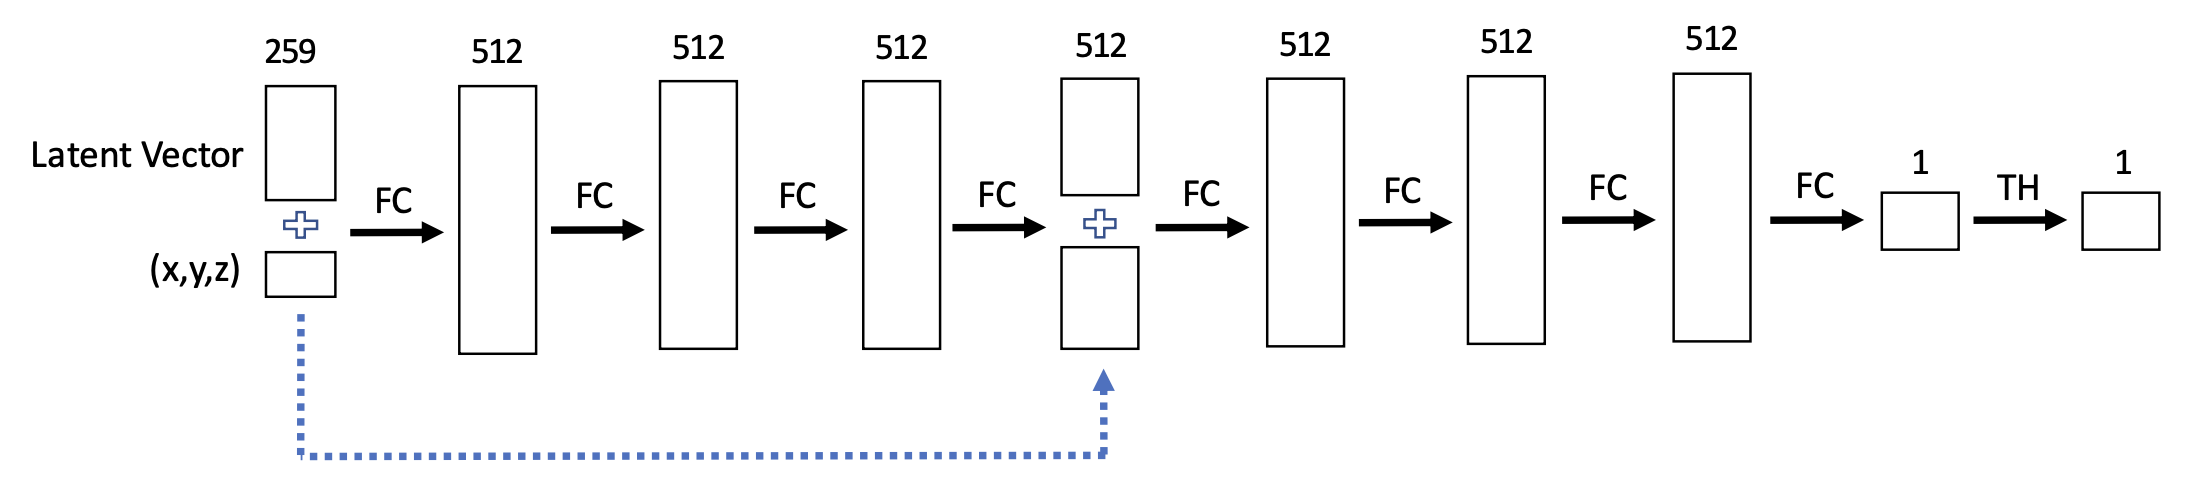

In [ ]:
# TODO: define other hyperparameters here

lipschitz_alpha = 1E-6

LR = 0.1
NUM_EPOCHS = 10
BATCH_SIZE = 256

P = 0.2                 # dropout probability
LATENT_DIM = 256
FC_DIM = [512] * 7

In [ ]:
# generate unique run id
run_id = str(int(time.time()))
if not os.path.exists('./experiments'):
    os.mkdir('./experiments')
os.mkdir('./experiments/%s' % run_id)
print("Saving models, predictions, and generated words to ./experiments/%s" % run_id)

# initialize models
model = DeepSDFDecoder(
        LATENT_DIM,
        FC_DIMS,
        # dropout=None,
        dropout_prob=P,
        # norm_layers=(),
        # latent_in=(),
        # weight_norm=False,
        # xyz_in_all=None,
        use_tanh=True,
        use_lip=True,
        # latent_dropout=False,
        )

loader = SDFDataLoader(dataset=dataset, batch_size=BATCH_SIZE)
trainer = Trainer(model, loader, max_epochs=NUM_EPOCHS, run_id=run_id, lr=LR)

Saving models, predictions, and generated words to ./experiments/1651892999


TypeError: ignored

In [ ]:
# Training Loop

best_nll = 1e30 
for epoch in range(NUM_EPOCHS):
    trainer.train()
    nll = trainer.test()
    if nll < best_nll:
        best_nll = nll
        print("Saving model, predictions and generated output for epoch "+str(epoch+1)+" with NLL: "+ str(best_nll))
        trainer.save()
    

In [ ]:
# plot training curves

plt.figure()
plt.plot(range(1, trainer.epochs + 1), trainer.train_losses, label='Training losses')
plt.plot(range(1, trainer.epochs + 1), trainer.val_losses, label='Validation losses')
plt.xlabel('Epochs')
plt.ylabel('NLL')
plt.legend()
plt.show()

In [ ]:
# see generated output
print (trainer.generated[-1]) # get last generated output